In [34]:
import pandas as pd
import numpy as np
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score
from sklearn import model_selection
from sklearn.base import TransformerMixin
from sklearn.model_selection import KFold
import matplotlib.pylab as plt
import matplotlib.patches as patches
from sklearn.metrics import roc_curve,auc
from numpy import interp
from joblib import dump
import os
import joblib
import timeit
from datetime import datetime

cwd = os.getcwd()
print(cwd)

G:\mlAlgos\dmml2


In [40]:
DT = 'DT'
DT_long = 'Decision Tree'
GNB = 'GNB'
GNB_long = 'Naive Bayes'
SVM = 'SVM'
SVM_long = 'Support Vector Machine'

### Data Preprocessing

In [3]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


def preprocess(df):
    df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']] = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']].replace('unknown', np.NaN)
    bank_object_data = df.select_dtypes(include="object")
    bank_non_object_data = df.select_dtypes(exclude="object")
    bank_object_data = DataFrameImputer().fit_transform(bank_object_data)
    label = LabelEncoder()
    bank_object_data = bank_object_data.apply(label.fit_transform)
    bank_final = pd.concat([bank_object_data, bank_non_object_data], axis = 1)
    return(bank_final)

In [5]:
df = pd.read_csv('bank-data/bank-additional-full.csv', sep = ';')
bank_final = preprocess(df)

## Function to output k-fold estimates of accuracy, recall, precision, f1, and roc_auc 

In [15]:
def kfold_output(model, X, Y): #function for kfold output
    start = timeit.default_timer()
    begin = datetime.now()
    scoring = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']

    kfold = KFold(n_splits=10, random_state=100, shuffle = True)
    results_kfold = model_selection.cross_validate(model, X, Y, scoring=scoring, cv=kfold)
    print("Recall: %0.2f (+/- %0.2f)" % (results_kfold['test_recall'].mean(), results_kfold['test_recall'].std()))
    print("Precision: %0.2f (+/- %0.2f)" % (results_kfold['test_precision'].mean(), results_kfold['test_precision'].std()))
    print("F1 Score: %0.2f (+/- %0.2f)" % (results_kfold['test_f1'].mean(), results_kfold['test_f1'].std()))
    print("Accuracy: %0.2f (+/- %0.2f)" % (results_kfold['test_accuracy'].mean(), results_kfold['test_accuracy'].std()))
    print("ROC_AUC: %0.2f (+/- %0.2f)" % (results_kfold['test_roc_auc'].mean(), results_kfold['test_roc_auc'].std()))
    
    print(results_kfold)
    
    stop = timeit.default_timer()
    end = datetime.now()
    print('Start Time: ', begin,
          'Stop Time: ', end,
          'Time Taken: ', stop - start)

## Function to print roc curves for k-fold validation sets alongwith their AUC

In [41]:
def classifier_roc(classifier, X_train_res, y_train_res):
    start = timeit.default_timer()
    begin = datetime.now()
    cv = KFold(n_splits=10, random_state=100, shuffle = True)
    cv_split_filenames = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    i = 1
    file_name = ''
    if type(classifier) == type(DecisionTreeClassifier()):
        file_name = DT
        plot_title = DT_long
    elif type(classifier) == type(GaussianNB()):
        file_name = GNB
        plot_title = GNB_long
    else:
        file_name = SVM
        plot_title = SVM_long
    
    if not os.path.exists(plot_title):
        os.mkdir(cwd+"/"+plot_title)
    
    for train, test in cv.split(X_train_res, y_train_res):
        probas_ = classifier.fit(X_train_res.iloc[train], y_train_res.iloc[train]).predict_proba(X_train_res.iloc[test])
        
        cv_split_filenames = cwd+"/"+plot_title + "/" + file_name + str(i)
        dump(probas_,cv_split_filenames)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train_res[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
                        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', 
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of ' + plot_title,fontsize=14)
    plt.legend(loc="lower right", prop={'size': 10})
    plt.show()
    stop = timeit.default_timer()
    end = datetime.now()
    print('Start Time: ', begin,
      'Stop Time: ', end,
      'Time Taken: ', stop - start)

## Function to plot roc curves using saved parameters

In [48]:
def plot_saved(directory,file_name, X_train_res,y_train_res):
    start = timeit.default_timer()
    begin = datetime.now()
    cv = KFold(n_splits=10, random_state=100, shuffle = True)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(10,10))
    i = 1
    for train, test in cv.split(X_train_res, y_train_res):
        probas_ = joblib.load(cwd +"/" + directory + "/" + file_name + str(i),mmap_mode = 'c')
         # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_train_res[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)     
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Cross-Validation ROC of '+ directory,fontsize=14)
    plt.legend(loc="lower right", prop={'size': 10})
    plt.show()
    stop = timeit.default_timer()
    end = datetime.now()
    print('Start Time: ', begin,
      'Stop Time: ', end,
      'Time Taken: ', stop - start)

## Building dataset for training

In [10]:
X_train_res = bank_final.drop(['y'], axis = 1)
y_train_res = bank_final['y']

## K-fold ouputs and ROC curve for Decision Tree classifier 

In [17]:
dt_classifier = DecisionTreeClassifier(min_samples_split=60, min_samples_leaf=60, class_weight = 'balanced', random_state=20)
kfold_output(dt_classifier,X_train_res,y_train_res)

Recall: 0.92 (+/- 0.01)
Precision: 0.42 (+/- 0.01)
F1 Score: 0.57 (+/- 0.01)
Accuracy: 0.85 (+/- 0.00)
ROC_AUC: 0.94 (+/- 0.00)
{'fit_time': array([0.71193695, 1.20095253, 0.56482244, 0.8163054 , 0.56401038,
       1.16261935, 0.99992967, 0.68744993, 0.59370804, 0.46871781]), 'score_time': array([0.09200048, 0.19287348, 0.1849246 , 0.05339003, 0.15143132,
       0.17186379, 0.09374571, 0.07812047, 0.07811904, 0.04687643]), 'test_accuracy': array([0.84729303, 0.85311969, 0.84340859, 0.84972081, 0.83636805,
       0.84680748, 0.84777859, 0.84098082, 0.84944148, 0.84725595]), 'test_recall': array([0.91397849, 0.89497717, 0.93528184, 0.90356394, 0.93075356,
       0.91823899, 0.92144374, 0.93023256, 0.89498807, 0.92222222]), 'test_precision': array([0.41913215, 0.41219769, 0.42184557, 0.42928287, 0.4165907 ,
       0.42524272, 0.42382812, 0.41431262, 0.39432177, 0.41129832]), 'test_f1': array([0.57471264, 0.56443485, 0.58144062, 0.58203916, 0.57556675,
       0.58128733, 0.58060201, 0.5732

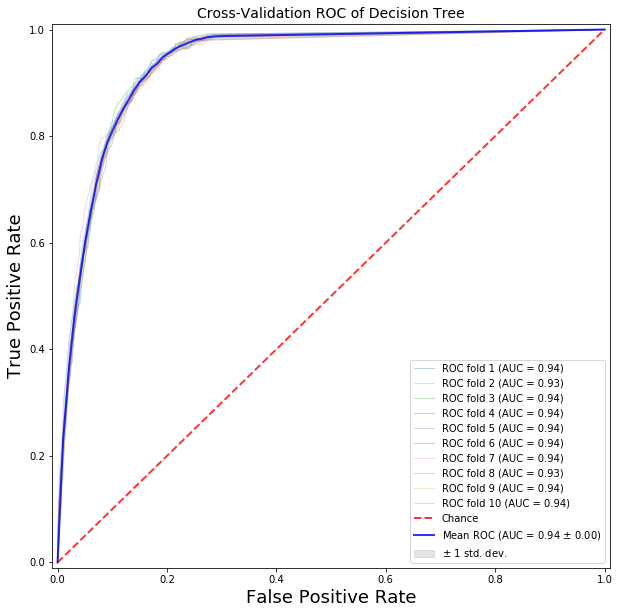

Start Time:  2020-04-22 17:56:42.113024 Stop Time:  2020-04-22 17:56:49.284727 Time Taken:  7.165144600000076


In [39]:
classifier_roc(dt_classifier, X_train_res, y_train_res)

## ROC curve for Decision Tree classifier using saved parameters

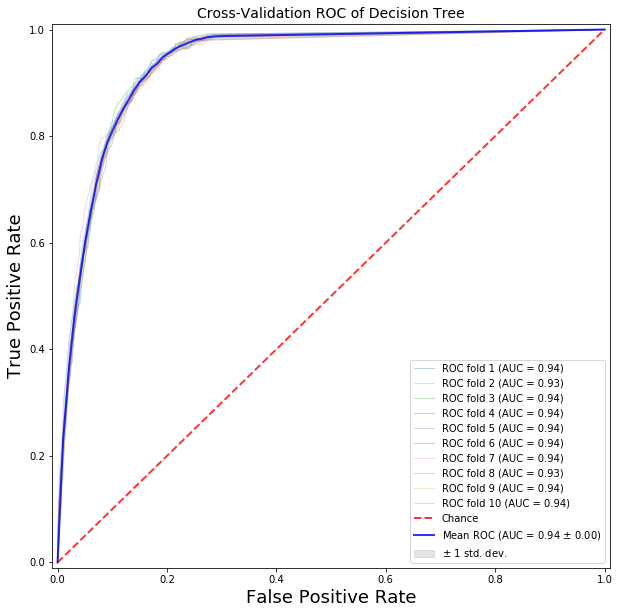

Start Time:  2020-04-22 18:19:43.936243 Stop Time:  2020-04-22 18:19:46.186086 Time Taken:  2.253601400000207


In [55]:
plot_saved(DT_long, DT, X_train_res,y_train_res)

## K-fold ouputs and ROC curve for Naive bayes classifier 

In [51]:
nb_classifier = GaussianNB(priors = [0.11, 0.89])
kfold_output(nb_classifier,X_train_res,y_train_res)

Recall: 0.83 (+/- 0.02)
Precision: 0.26 (+/- 0.01)
F1 Score: 0.40 (+/- 0.02)
Accuracy: 0.72 (+/- 0.01)
ROC_AUC: 0.86 (+/- 0.01)
{'fit_time': array([0.25413251, 0.24368906, 0.2545886 , 0.23408699, 0.27425313,
       0.12216473, 0.11410284, 0.1837728 , 0.11969519, 0.13152647]), 'score_time': array([0.19289875, 0.21304655, 0.25378799, 0.17281079, 0.1319139 ,
       0.08921123, 0.1014874 , 0.12158918, 0.08120394, 0.09375787]), 'test_accuracy': array([0.70648216, 0.72371935, 0.72177713, 0.72881767, 0.71279437,
       0.7157077 , 0.7038116 , 0.72226269, 0.71345313, 0.73288004]), 'test_recall': array([0.8       , 0.81050228, 0.84968685, 0.83438155, 0.82688391,
       0.83438155, 0.80254777, 0.8435518 , 0.82338902, 0.84222222]), 'test_precision': array([0.25      , 0.25177305, 0.27481431, 0.27715877, 0.26994681,
       0.26711409, 0.25116279, 0.27161334, 0.23776706, 0.26917614]), 'test_f1': array([0.38095238, 0.38419913, 0.41530612, 0.41610037, 0.40701754,
       0.40467717, 0.38259109, 0.4109

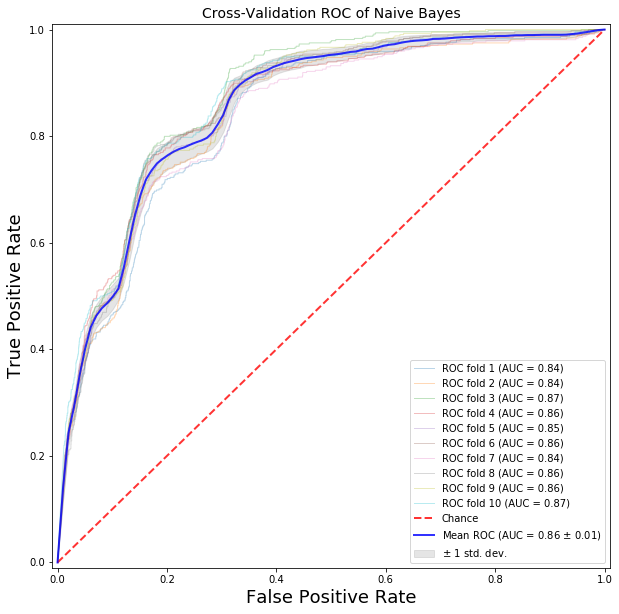

Start Time:  2020-04-22 18:11:59.956740 Stop Time:  2020-04-22 18:12:03.281920 Time Taken:  3.3335039999997207


In [52]:
classifier_roc(nb_classifier, X_train_res, y_train_res)

## ROC curve for Naive Bayes classifier using saved parameters

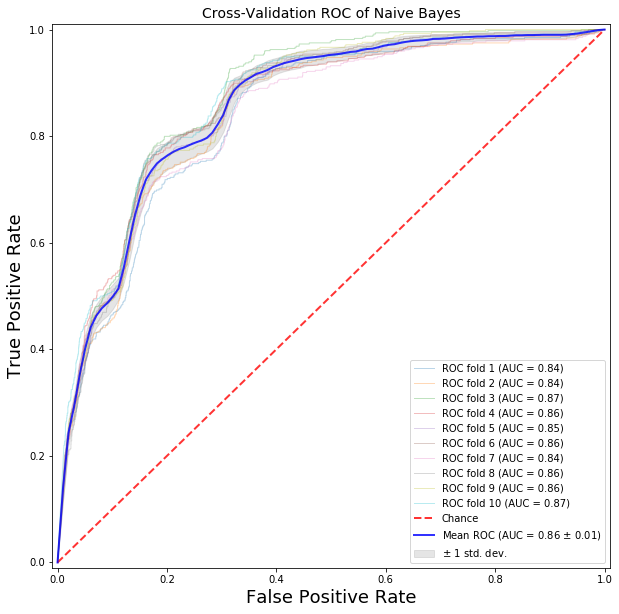

Start Time:  2020-04-22 18:13:35.465641 Stop Time:  2020-04-22 18:13:37.512382 Time Taken:  2.05351359999986


In [54]:
plot_saved(GNB_long, GNB, X_train_res,y_train_res)

## K-fold ouputs and ROC curve for SVM with plynomial kernel

In [ ]:
svm_classifier = SVC(kernel = 'poly', random_state = 0, class_weight = 'balanced')
kfold_output(svm_classifier,X_train_res,y_train_res)

C:\Users\ashish\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


## ROC curve for SVM classifier using saved parameters

In [ ]:
plot_saved(SVM_long, SVM, X_train_res,y_train_res)